# **Waze Project**

**Scenario** 

Build a machine learning model to predict user churn for a ride-sharing company called Waze. The results should help leadership at Waze make informed business decisions to prevent user churn, improve user retention, and grow Waze’s business. 

To get the best results, we will build and test two tree-based models: random forest and XGBoost.

**The purpose** is to find factors that drive user churn.

**The goal** is to predict whether or not a Waze user is retained or churned.
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations

**Part 2:** Feature engineering

**Part 3:** Modeling



## Ethical considerations


I'm asked to build a machine learning model to predict user churn. The implications of errors in the model mostly impacts the business negatively in terms of resources. In terms of ethical considerations, the risk is minimal.  

* The effect of a false negative is unexpected user churn which could have been avoided if the error had not occured.

* The effect of a false positive could be unneccessary loss of resources in attempts to mitigate the churn of customers that are not churning.

The benefits of a sound model has the potential to outweigh the potential problems, if it's accurate enough. Based on the considerations above, I would be comfortable with proceeding with the request and build the model. 


## Imports and data loading

In [2]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# # This module lets us save our models once we fit them.
import pickle

In [3]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [4]:
# Inspect the first five rows
df0.head()

ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226      296.748273                     2276   
1   1  retained       133     107      326.896596                     1225   
2   2  retained       114      95      135.522926                     2651   
3   3  retained        49      40       67.589221                       15   
4   4  retained        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days   device  
0              1985.775061             28            19  Android  
1              3160.472914             13            11   iPhone  
2              1610.735904             14             8  Android  
3               587.196542              7             3   iPhone  
4              1219.555924             27            18  Android

## Feature engineering

In [5]:
# Copy the df0 dataframe
df = df0.copy()

Call `info()` on the new dataframe so the existing columns can be easily referenced.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

Let's create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.



In [7]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Some values are infinite. This is the result of there being values of zero in the `driving_days` column. Let's convert these values from infinity to zero. 

In [8]:
# 1. Convert infinite values to zero
df['km_per_driving_day'] = df['km_per_driving_day'].replace(np.inf, 0)

## Exemplar suggested this method: df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

Let's create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

In [9]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

Let's create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [10]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

#### **`total_sessions_per_day`**

Let's create a new column that represents the mean number of sessions per day _since onboarding_.

In [11]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [12]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Let's create a column representing the mean kilometers per hour driven in the last month.

In [13]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives']/60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**

Let's create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [14]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Let's convert the infinite values to zero.

In [15]:
# 1. Convert infinite values to zero
df['km_per_drive'] = df['km_per_drive'].replace(np.inf, 0)

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, let's create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [16]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

#### Drop missing values

We know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, we use the `dropna()` method to drop the rows that are missing this data.

In [ ]:
# Drop rows with missing values
df = df.dropna(subset=['label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14299 non-null  int64  
 1   label                            14299 non-null  object 
 2   sessions                         14299 non-null  int64  
 3   drives                           14299 non-null  int64  
 4   total_sessions                   14299 non-null  float64
 5   n_days_after_onboarding          14299 non-null  int64  
 6   total_navigations_fav1           14299 non-null  int64  
 7   total_navigations_fav2           14299 non-null  int64  
 8   driven_km_drives                 14299 non-null  float64
 9   duration_minutes_drives          14299 non-null  float64
 10  activity_days                    14299 non-null  int64  
 11  driving_days                     14299 non-null  int64  
 12  device                 

#### Outliers

We know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Variable encoding**

#### **Dummying features**

In order to use `device` as an X variable, we will need to convert it to binary, as this variable is categorical.

Because this dataset only has one remaining categorical feature (`device`), we can just implement the transformation directly, without using pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) functions.

So we just create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [18]:
# Create new `device2` variable
df['device2'] = df['device'].map({'Android':0, 'iPhone':1})

df.groupby(df['device'])['device2'].value_counts()

device   device2
Android  0          5074
iPhone   1          9225
Name: count, dtype: int64

#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained." Let's change the data type of the `label` column to binary. This change is needed to train the models.

In [19]:
# Create binary `label2` column
df['label2'] = df['label'].map({'retained':0, 'churned':1})


df.groupby(df['label'])['label2'].value_counts()

label     label2
churned   1          2536
retained  0         11763
Name: count, dtype: int64

### Feature selection

Tree-based models can handle multicollinearity, so the only feature we drop is `ID`, since it doesn't contain any information relevant to churn.

In [20]:
# Drop `ID` column
df = df.drop(['ID'], axis=1)

### Evaluation metric

Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, let's examine the class balance of the target variable.

In [21]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, let's consider which evaluation metric is best. Accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, we select the model based on the recall score.

## Modeling

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. Split the data into train/validation/test sets (60/20/20)

2. Fit models and tune hyperparameters on the training set

3. Perform final model selection on the validation set

4. Assess the champion model's performance on the test set

<img src="https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg" width="800">


### Split the data

In [22]:
# 1. Isolate X variables
X = df.drop(['label', 'label2', 'device'], axis=1)

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)


Verify the number of samples in the partitioned data.

In [23]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


This aligns with expectations.

### **Random forest**

In [24]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [3, 10, None],
             'max_features': [1.0, 3.0, 5.0],
             'max_samples': [1.0, 10.0, 50.0],
             'min_samples_leaf': [2, 10, 50],
             'min_samples_split': [2, 10, 50],
             'n_estimators': [100]
            }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Fit the model to the training data.

In [25]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 10min 33s, sys: 340 ms, total: 10min 34s
Wall time: 10min 34s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 10, None],
                         'max_features': [1.0, 3.0, 5.0],
                         'max_samples': [1.0, 10.0, 50.0],
                         'min_samples_leaf': [2, 10, 50],
                         'min_samples_split': [2, 10, 50],
                         'n_estimators': [100]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

Examine the best average score across all the validation folds.

In [26]:
# Examine best score
rf_cv.best_score_

0.12876087857438873

Examine the best combination of hyperparameters.

In [27]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

Output all of the scores of the model. 

In [29]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [30]:
results = make_results('RF cv', rf_cv, 'recall')
results

model  precision    recall        F1  accuracy
0  RF cv   0.473032  0.128761  0.202378  0.820025

Asside from the accuracy, the scores aren't that good. 

### **XGBoost**

 Let's try to improve our scores using an XGBoost model.

In [31]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]}

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'recall', 'precision', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the `X_train` and `y_train` data.

In [32]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 1min 7s, sys: 668 ms, total: 1min 8s
Wall time: 34.6 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'recall', 'precision', 'f1'])

Get the best score from this model.

In [33]:
# Examine best score
xgb_cv.best_score_

0.1708264263019754

And the best parameters.

In [34]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

Output all of the scores of the model.

In [35]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

model  precision    recall        F1  accuracy
0   RF cv   0.473032  0.128761  0.202378  0.820025
0  XGB cv   0.425932  0.170826  0.243736  0.811866

This model fit the data better than the random forest model. The recall score is almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### Model selection

Now, let's use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [36]:
# Use random forest model to predict on validation data

rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Generate a table of scores from the predictions on the validation data.

In [37]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [38]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

model  precision    recall        F1  accuracy
0   RF cv   0.473032  0.128761  0.202378  0.820025
0  XGB cv   0.425932  0.170826  0.243736  0.811866
0  RF val   0.439490  0.136095  0.207831  0.816084

Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Now, let's do the same thing to get the performance scores of the XGBoost model on the validation data.

In [39]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

model  precision    recall        F1  accuracy
0    RF cv   0.473032  0.128761  0.202378  0.820025
0   XGB cv   0.425932  0.170826  0.243736  0.811866
0   RF val   0.439490  0.136095  0.207831  0.816084
0  XGB val   0.422680  0.161736  0.233951  0.812238

The XGBoost model's validation scores dropped slightly, it is still the clear champion.

### Use champion model to predict on test data

Now, let's use the champion model to predict on the test dataset to give indication of how we should expect the model to perform on new future data.

In [40]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

model  precision    recall        F1  accuracy
0     RF cv   0.473032  0.128761  0.202378  0.820025
0    XGB cv   0.425932  0.170826  0.243736  0.811866
0    RF val   0.439490  0.136095  0.207831  0.816084
0   XGB val   0.422680  0.161736  0.233951  0.812238
0  XGB test   0.423963  0.181460  0.254144  0.811189

All scores except accuracy increased very slightly. 

### Confusion matrix

Let's plot a confusion matrix of the champion model's predictions on the test data.

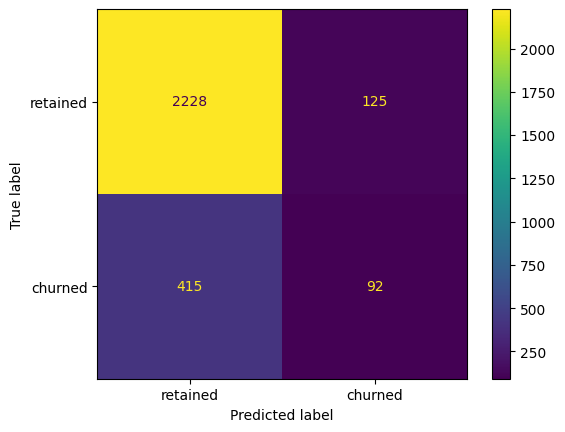

In [41]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = ['retained', 'churned']
                             )
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 18.1% of the users who actually churned.

The model is not a strong enough predictor to used to drive consequential business decisions, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value.

### Feature importance

Inspect the most important features of the final model.

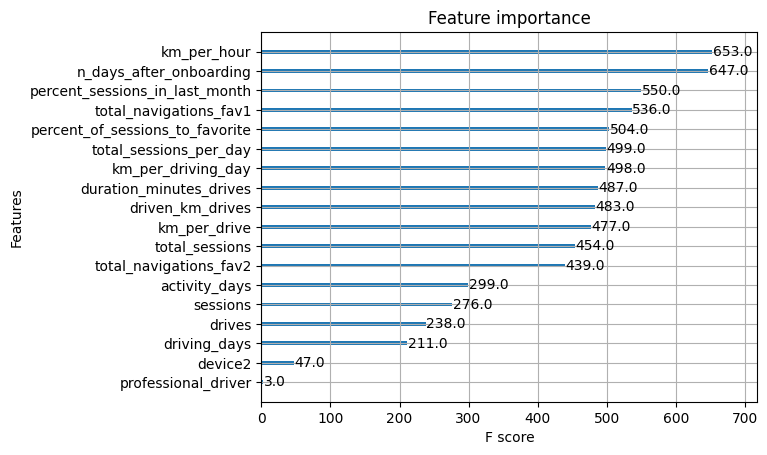

In [42]:
plot_importance(xgb_cv.best_estimator_);

### **Bonus: Identify an optimal decision threshold**

The default decision threshold for most implementations of classification algorithms&mdash;including scikit-learn's&mdash;is 0.5. This means that, in the case of the Waze models, if they predicted that a given user had a 50% probability or greater of churning, then that user was assigned a predicted value of `1`&mdash;the user was predicted to churn.

With imbalanced datasets where the response class is a minority, this threshold might not be ideal.

Here's the precision-recall curve for the XGBoost champion model on the test data.

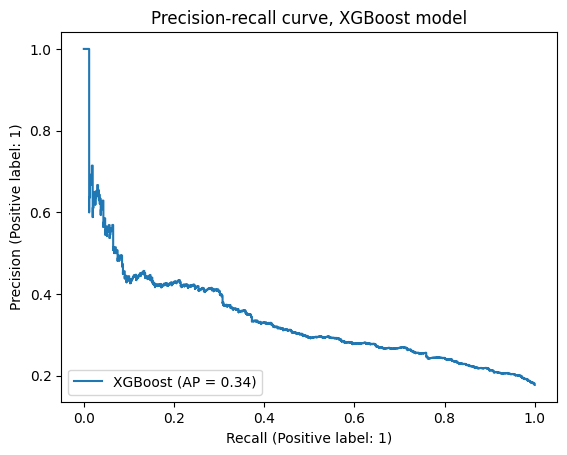

In [43]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

As recall increases, precision decreases. But what if we determined that false positives aren't much of a problem? For example, in the case of this Waze project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.

So, what if instead of using the default 0.5 decision threshold of the model, we used a lower threshold?

Here's an example where the threshold is set to 0.4:

In [44]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.94572806, 0.05427192],
       [0.57626796, 0.42373207],
       [0.98132175, 0.01867823],
       ...,
       [0.8135836 , 0.18641639],
       [0.9661311 , 0.03386891],
       [0.7386279 , 0.26137212]], dtype=float32)

In [45]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 1, 0, ..., 0, 0, 0])

In [46]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

model  precision    recall        F1  accuracy
0  XGB, threshold = 0.4   0.414986  0.284024  0.337237  0.802098

Compare these numbers with the results from earlier.

In [47]:
results

model  precision    recall        F1  accuracy
0     RF cv   0.473032  0.128761  0.202378  0.820025
0    XGB cv   0.425932  0.170826  0.243736  0.811866
0    RF val   0.439490  0.136095  0.207831  0.816084
0   XGB val   0.422680  0.161736  0.233951  0.812238
0  XGB test   0.423963  0.181460  0.254144  0.811189

Recall and F1 score increased significantly, while precision and accuracy decreased marginally.

So, using the precision-recall curve as a guide, suppose we'd be satisfied if the model had a recall score of 0.5 and we were willing to accept the \~30% precision score that comes with it. In other words, we'd be happy if the model successfully identified half of the people who will actually churn, even if it means that when the model says someone will churn, it's only correct about 30% of the time.

What threshold will yield this result? There are a number of ways to determine this. Here's one way to do it using a function.

In [48]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


Now, test the function to find the threshold that results in a recall score closest to 0.5.

In [49]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(0.194, 0.4990138067061144)

Setting a threshold of 0.194 will result in a recall of 0.499.

To verify, you can repeat the steps performed earlier to get the other evaluation metrics for when the model has a threshold of 0.194. Based on the precision-recall curve, a 0.5 recall score should have a precision of \~0.3.

In [50]:
# Create an array of new predictions that assigns a 1 to any value >= 0.194
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.194 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.194
get_test_scores('XGB, threshold = 0.194', new_preds, y_test)

model  precision    recall        F1  accuracy
0  XGB, threshold = 0.194   0.293163  0.499014  0.369343  0.697902

It worked! Changing the decision threshold is another tool that can help achieve useful results from models.